# M3 Reconstruction
### Using the 3 highest P_{T} jets Lorentz Vector to construct and invariant mass. Known as M3 Reconstruction
By Zach Shelton
01/25/2021

In [1]:
#NanoAOD HackSchema
#Solution from Danny Noonan


In [229]:
from __future__ import print_function, division
import uproot
import uproot_methods
import numpy as np
#Make sure to install both old awkward0 and new awkward1(referred to now as awkward)
import awkward as ak
import awkward1 as ak0
from coffea.nanoevents import NanoAODSchema,NanoEventsFactory
from uproot_methods import TLorentzVectorArray
import uproot3_methods
import numpy as np
import awkward
class HackSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        base_form["contents"].pop("Electron_photonIdx", None)
        super().__init__(base_form)
def m3_recon(tree):
    comb= ak0.combinations(tree,n=3,axis=1,fields=['j1','j2','j3'])
    trijets= comb.j1+comb.j2+comb.j3
    recon =ak0.max(trijets,axis=1)
    reconfinal=np.sqrt(recon.t*recon.t-recon.x*recon.x-recon.y*recon.y-recon.z*recon.z)
    #MISUSE/CONFUSION:
    #for some reason None values are being placed in array
    #So I reconstructed the mass "manually"
    list1= ak0.to_numpy(postcuts_m3)
    return list1
files ="TTbarPowheg_Semilept_Skim_NanoAOD_1of21.root"

## Note: It seems the Jet columns are sorted from greatest p_t to smallest p_t
Feel free to test, but it seems to be my observation, choosing the 1st, 2nd or 3rd jet via index should remove the issue of it being a coffea sorting artifact or procedure

This seems a lot higher than 173 Gev for the Top quark, I will note in research there are additional bins and tagging I could add to increase accuracy. Like for instance, a matched Muon or Electron.

In [230]:
#Now lets redo with the cuts detailed by CMS Draft Analysis
#https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view
events =NanoEventsFactory.from_root(files,schemaclass=HackSchema).events()
#Is this step necessary? I find reference issues when I do the masking
#NOTE: Total Events tree has been replaced with just Jet Tree

In [237]:
#From table 11, taking direct cuts. 
non_cut= events
no_cutsrecon=m3_recon(non_cut.Jet)
#print(events.Jet.cleanmask)
events.Jet=events.Jet[(events.Jet.pt>30)]
#print(len(events.Jet.pt))
events.Jet=events.Jet[(abs(events.Jet.eta)<2.4)]#eta tag
#print(len(events.Jet.pt))
events.Jet=events.Jet[((events.Jet.btagCSVV2>.4841))]#B-tag
print(len(events.Jet.pt))
simplecuts =events
simpcutsrecon=m3_recon(simplecuts.Jet)
#slightcuts_recon= create_sum(events.Jet)

720126


In [238]:
#Filtering out events without leptons
mask=((ak0.sum(events.Jet.nMuons,axis=1)==1)|(ak0.sum(events.Jet.nElectrons,axis=1)==1))
events=events[mask]

In [239]:
leptoncuts=events
print(len(events))

720126


In [240]:
#post_cutsM3=m3_recon(events)
postcuts_m3=(m3_recon(leptoncuts.Jet))

<AxesSubplot:xlabel='p_{t}', ylabel='p_t Comparison'>

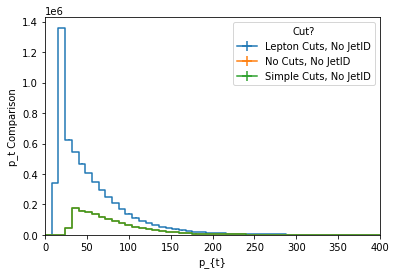

In [241]:
import coffea.hist as hist
cat=hist.Cat("cut","Cut?")
bins=hist.Bin("p_t","p_{t}",50,0,400)
histogram= hist.Hist("p_t Comparison",cat,bins)
histogram.fill(cut="No Cuts, No JetID",p_t=ak0.flatten(non_cut.Jet.pt))
histogram.fill(cut="Simple Cuts, No JetID",p_t=ak0.flatten(simplecuts.Jet.pt))
histogram.fill(cut="Lepton Cuts, No JetID",p_t=ak0.flatten(leptoncuts.Jet.pt))
hist.plot1d(histogram,overlay='cut')

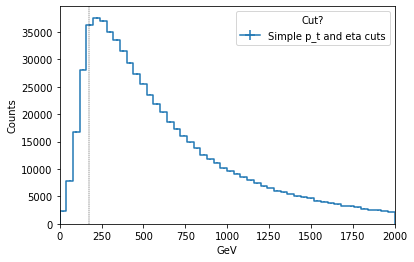

In [250]:
#M3 Reconstruction
import matplotlib.pyplot as plt
cat=hist.Cat("cut","Cut?")
bins=hist.Bin("M3","GeV",50,0,2000)
histogram= hist.Hist("Counts",cat,bins)
#histogram.fill(cut="Lepton Cuts",M3=postcuts_m3)
#histogram.fill(cut="No Cuts",M3=no_cutsrecon)
histogram.fill(cut="Simple p_t and eta cuts",M3=simpcutsrecon)
fig=hist.plot1d(histogram,overlay='cut',density=False)
fig.axvline(173, color='k', linestyle='dashed', linewidth=.4)

## What's next??
- Jet TightID
- More 
- Particle Values
- Delta R

Wrap into Coffea Executor
Seperate values, weights and triggers
read these into tensors for Keras
Best ML Algorithm?
- Deep Neural Net
- Iterative Boosted Tree
    - They are fast
    - External ML algorithm modifies BDT parameters
- Combine old processes together
Should I use Keras or PyTorch?


## Sources/Further Reading:

CMS Draft Analysis Note(FIT, AAS, Wayne State, NISTR): https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view

Invariant Mass Wikipedia Article: https://en.wikipedia.org/wiki/Invariant_mass

Measurement of the semileptonic tt + γ production cross-section in pp collisions at √s = 8 Tev: https://arxiv.org/pdf/1706.08128.pdf

Coffea Documentation: https://coffeateam.github.io/coffea/

Awkward Array Documentation: https://awkward-array.readthedocs.io/en/latest/

# Will be availible on Github: under username zshelton2015